# AirBnB Kaggle Competition

Predicting in which country a new user will make their first apartment bookings using the AirBnB data provided during their Kaggle Competition.

In [16]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Once we have imported all the necessary packages. Let's load the data:

In [4]:
path = "./data/"
trainDF = pd.read_csv(path + 'train_users_2.csv')
testDF = pd.read_csv(path + 'test_users.csv')
df = pd.concat([trainDF, testDF])

trainDF.df_name = 'Training Data'
testDF.df_name = 'Test Data'
print('The number of observations in training data:', len(trainDF))
print('The number of observations in test data:', len(testDF))
print('Total number of observations:', len(df))

The number of observations in training data: 213451
The number of observations in test data: 62096
Total number of observations: 275547


The column __`country_destination`__ is the output (dependent) variable which we're going to predict. Let's see the categories in it (different destinations) and the number of observations in each category. The output variable is the last column in the training data ->  we can use `iloc[:, -1]` indexing to get it.

In [5]:
df2 = pd.concat([trainDF.iloc[:, -1].value_counts(), np.round(trainDF.iloc[:, -1].value_counts() / len(trainDF) * 100, 2)],
                axis=1)
df2.columns = ['count', 'percent']
print(df2)

        count  percent
NDF    124543    58.35
US      62376    29.22
other   10094     4.73
FR       5023     2.35
IT       2835     1.33
GB       2324     1.09
ES       2249     1.05
CA       1428     0.67
DE       1061     0.50
NL        762     0.36
AU        539     0.25
PT        217     0.10


Almost 60% of the observations are in the `NDF` category. `NDF` stands for No Destination Found - indicating that there was no booking. Of all the bookings, an overwhelming majority was in the US. `other` is an aggregation of all countries other than those specifically listed.



Let's take a look at some of the data and see which columns have missing values.

In [6]:
print(df.head(9))
print(' .\n', '.\n' , '.\n')
print(df.tail(9))
print('\n', '\n')
print('                   Number of missing values')
print(len(df) - df.count()[df.count() < len(df)])  # columns with missing values

  affiliate_channel affiliate_provider   age country_destination  \
0            direct             direct   NaN                 NDF   
1               seo             google  38.0                 NDF   
2            direct             direct  56.0                  US   
3            direct             direct  42.0               other   
4            direct             direct  41.0                  US   
5             other              other   NaN                  US   
6             other         craigslist  46.0                  US   
7            direct             direct  47.0                  US   
8             other         craigslist  50.0                  US   

  date_account_created date_first_booking first_affiliate_tracked  \
0           2010-06-28                NaN               untracked   
1           2011-05-25                NaN               untracked   
2           2010-09-28         2010-08-02               untracked   
3           2011-12-05         2012-09-08  

In [7]:
print('The number of observations in training data:', len(trainDF))
print('The number of observations in test data:', len(testDF))
print('Total number of observations:', len(df))

The number of observations in training data: 213451
The number of observations in test data: 62096
Total number of observations: 275547


The number of missing values in the __`country_destination`__ column is exactly equal to the number of observations in the test data: $62,096$. That's because this is the variable to be predicted.
So, there are three columns, that we should focus on, with missing values. __`age`__, __`date_first_booking`__ and __`first_affiliate_tracked`__. The latter has relatively very few missing values (only $6,085$ missing out of $275,547$ observations).

Let's take a closer look at __`date_first_booking`__:

In [8]:
for x in (trainDF, testDF):
    print('Number of missing values in {} are {}'.
          format(x.df_name, len(x.date_first_booking) - x.date_first_booking.count()[x.date_first_booking.count() < len(x)][0]))

Number of missing values in Training Data are 124543
Number of missing values in Test Data are 62096


So, the __`date_first_booking`__ column in the test data is all `NaN`. In the training data, the missing values are exactly equal to the number of `NDF`(no booking) observations. This makes sense, if no booking was done, then the date of the first booking for that user is `NaN`. Conclusion: this feature will not be of much help in predicting booking destination and can be dropped.

There are two other columns with timestamps, so we need to convert them into datetime using `pd.to_datetime`. These two columns indicate the time of a user's first activity (__`timestamp_first_active`__) and the date they created an account (__`date_account_created`__). The time elapsed between these two points of time can also be of potential use later for predicting booking destinations. So, I also create a new feature called __`days_to_registration`__ which is equal to __`date_account_created`__ minus __`timestamp_first_active`__. The difference between two datetime objects in `pandas` returns at `timedelta` object with elapsed days and hours (in our case, even minutes and seconds), but we're satisfied with just the number of days.

In [9]:
df['timestamp_first_active'] = pd.to_datetime(df.timestamp_first_active, format='%Y%m%d%H%M%S')
df['date_account_created'] = pd.to_datetime(df.date_account_created, format='%Y-%m-%d')
df['days_to_registration'] = (df.date_account_created - df.timestamp_first_active).dt.days
print(df.timestamp_first_active.head())
print('\n', df.date_account_created.head())
print('\n', df.days_to_registration.head(10))

0   2009-03-19 04:32:55
1   2009-05-23 17:48:09
2   2009-06-09 23:12:47
3   2009-10-31 06:01:29
4   2009-12-08 06:11:05
Name: timestamp_first_active, dtype: datetime64[ns]

 0   2010-06-28
1   2011-05-25
2   2010-09-28
3   2011-12-05
4   2010-09-14
Name: date_account_created, dtype: datetime64[ns]

 0    465
1    731
2    475
3    764
4    279
5     -1
6     -1
7     -1
8     -1
9     -1
Name: days_to_registration, dtype: int64


Most of the observations in the new __`days_to_registration`__ feature are equal to (-1), meaning that the most users created and account and were first active the next day. This doesn't sound right:


In [10]:
df.days_to_registration.value_counts()

-1       275369
 0            7
 6            4
 5            4
 1            4
 2            3
 3            3
 4            3
 28           3
 94           2
 633          2
 56           2
 721          2
 311          2
 162          2
 102          2
 175          2
 39           2
 36           2
 19           2
 103          2
 8            2
 16           1
 258          1
 327          1
 73           1
 330          1
 586          1
 75           1
 77           1
          ...  
 107          1
 363          1
 621          1
 110          1
 366          1
 368          1
 881          1
 115          1
 117          1
 123          1
 635          1
 1147         1
 124          1
 131          1
 153          1
 132          1
 136          1
 137          1
 394          1
 142          1
 398          1
 143          1
 400          1
 145          1
 657          1
 658          1
 149          1
 152          1
 664          1
 105          1
Name: days_to_registrati

This issue is caused by the fact that the __`date_account_created`__ feature is formatted as "Year-month-day", but it really has the format "Year-month-day 00:00:00". The __`timestamp_first_active`__ feature has a "Year-month-day Hour:minute:second" format. So, when we difference them, the user that registered and were first active on the same day get a timedelta of -1 days. 

We can replace -1 with 0 to address this issue.

In [11]:
df.days_to_registration.replace(-1, 0, inplace=True)
df.days_to_registration.value_counts()

0       275376
1            4
6            4
5            4
3            3
28           3
4            3
2            3
56           2
311          2
721          2
162          2
102          2
633          2
175          2
39           2
36           2
94           2
19           2
103          2
8            2
594          1
837          1
327          1
73           1
330          1
586          1
75           1
77           1
79           1
         ...  
361          1
107          1
363          1
621          1
110          1
366          1
368          1
881          1
115          1
117          1
123          1
635          1
1147         1
128          1
664          1
131          1
132          1
136          1
137          1
394          1
142          1
398          1
143          1
400          1
145          1
657          1
658          1
149          1
152          1
615          1
Name: days_to_registration, dtype: int64

We can see that almost all users were active on the same day of account creation. Moreover, another data set called `sessions` has a lot less per user id observations than this `users` data set. So, when we do an inner join of the two data sets, there is a high chance the non-zero values of the __`days_to_registration`__ feature will be dropped. Hence, this feature will be of no use and we can drop it now.


In [12]:
df.drop(['days_to_registration'], axis=1, inplace=1)

Now that we have converted the time columns into datetime object, we can use them to, for instance, analyze the accumulation of new registered users of AirBnB.
The registered user base has certainly accelerated during 2013 and 2014 as we can see from the graph below. The training data for predicting the booking destination is until 2014-06-30. From 2014-07-01 and on, the test data starts. 

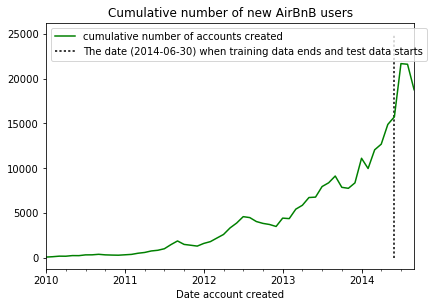

In [13]:
accounts_created = pd.DataFrame(df.date_account_created.value_counts())
accounts_created.date_account_created.resample('m').sum().plot(label='cumulative number of accounts created', color='g')
plt.vlines('2014-06-30', ymin=0, ymax=25000, linestyles='dotted',
           label='The date (2014-06-30) when training data ends and test data starts')
plt.tight_layout()
plt.title('Cumulative number of new AirBnB users')
plt.legend(loc='upper left')
plt.xlabel('Date account created')
plt.show()

Let's extract some more information from the time columns.

The __`timestamp_first_active`__ column shows year, month, day, hour, minute and second data, while the __`date_account_created`__ column shows only year, month and day. We can break out these features into separate time interval columns in order to get more useful information for predictive analytics purposes:

In [14]:
df['year_first_active'] = df.timestamp_first_active.dt.year
df['month_first_active'] = df.timestamp_first_active.dt.month
df['day_first_active'] = df.timestamp_first_active.dt.dayofweek
df['hour_first_active'] = df.timestamp_first_active.dt.hour

df['year_account_created'] = df.date_account_created.dt.year
df['month_account_created'] = df.date_account_created.dt.month
df['day_account_created'] = df.date_account_created.dt.dayofweek
df = df.drop(['date_first_booking', 'timestamp_first_active', 'date_account_created'], axis=1)
df.head()

,affiliate_channel,affiliate_provider,age,country_destination,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,year_first_active,month_first_active,day_first_active,hour_first_active,year_account_created,month_account_created,day_account_created
0,direct,direct,NaN,NDF,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,2009,3,3,4,2010,6,0
1,seo,google,38.0,NDF,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,2009,5,5,17,2011,5,2
2,direct,direct,56.0,US,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,2009,6,1,23,2010,9,1
3,direct,direct,42.0,other,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,2009,10,5,6,2011,12,0
4,direct,direct,41.0,US,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,2009,12,1,6,2010,9,1


We're done with the time columns. Now, let's fix the __`age`__ feature, which has about 40% missing values. Not many people are willing to provide their age. Moreover, out of the ones that do provide it, the data is entered in different formats: some people have entered their birth year instead of age:

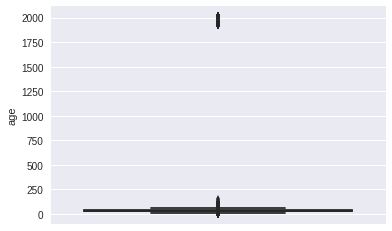

In [17]:
plt.clf()
sns.boxplot(df.age, orient='v', color='g')
plt.show()

We can see on the boxplot above, that there is a bunch of values around the 2000 threshold. Let's plot another boxplot, but now without those values:

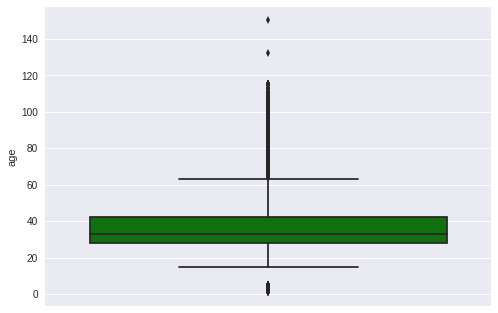

In [18]:
plt.clf()
sns.boxplot(df.age[df.age <= df.age[df.age < 1000].max()], orient='v', color='g')
plt.show()

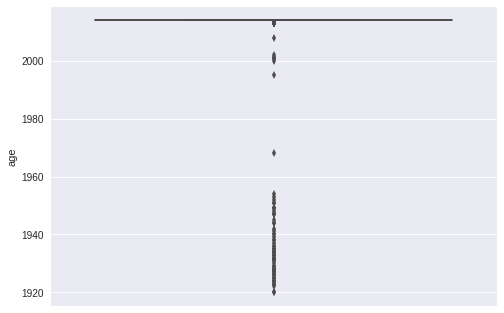

In [19]:
plt.clf()
sns.boxplot(df.age[df.age >= df.age[df.age > 1000].min()], orient='v')
plt.show()

From the boxplot above we can see that some of the extremely high values are birthyears, and many (the ones that are around 2010) are just errors. We can transform the birthyears into ages by subtracting the age (birthyear) value from the year the account was created for those values where the difference is positive. We don't want negative age result (for instance a use registered in 2010 and gave 2014 as their age/birthyear, which would result in 2010 - 2014 = -4):

In [20]:
df['age'] = np.where((df.age >= 1920) & (df.age < df.year_account_created), df.year_account_created - df.age, df.age)

Let's take a look at the age value counts below age 18 and above age 85 now: 

In [21]:
age_counts = df.age.groupby(df.age).count()
print(age_counts[:17])
age_counts[86:]

age
1.0      7
2.0      7
4.0      3
5.0     45
6.0      1
12.0     1
13.0     5
14.0     1
15.0     9
16.0    39
17.0    81
Name: age, dtype: int64


age
86.0        35
87.0        37
88.0        18
89.0        18
90.0        24
91.0        16
92.0        19
93.0        21
94.0        19
95.0        61
96.0        27
97.0        13
98.0        17
99.0        19
100.0       31
101.0       40
102.0       39
103.0       30
104.0       52
105.0     1351
106.0       20
107.0       28
108.0       16
109.0       36
110.0      228
111.0        2
112.0        1
113.0        4
115.0       13
132.0        1
150.0        1
2013.0      36
2014.0     710
Name: age, dtype: int64

Here, I will make a subjective judgement that, people younger than 16 and older than 90 wouldn't be travelling and booking apartments on AirBnB. Perhaps, I could stretch it to 15 - 95 range, but that will only be adding 145 observations (too small a value to make big difference, I suppose).

In [22]:
df['age'] = np.where((df.age < 16) | (df.age > 90), np.nan, df.age)

Finally, we need to incorporate the information in the __`age`__ feature related to all the `NaN` values. There is a large amount of them and they can potentially be useful for predictive analysis. So, we can turn them into a category of their own. This can be done by replacing the missing values with, for example, 999.

In [23]:
df['age'].replace(np.nan, 999, inplace=True)

It is better to discretize the __`age`__ feature by dividing it into bins of a width equal 5 years. The new categorical age variable is called __`age_cats`__:

In [24]:
bins = [df.age.min()-1, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 90, df.age.max()]
labels = [ "{0} - {1}".format(i, i + 4) for i in range(16, 66, 5) ]
labels.extend(['66 - 90', '999'])
df['age_cats'] = pd.cut(df.age, bins, labels=labels)
df = df.drop(['age'], axis=1)

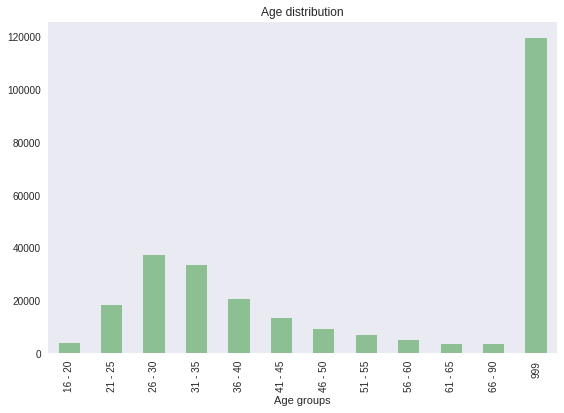

In [25]:
plt.clf()
df['age_cats'].value_counts(sort=0).plot(kind='bar', color='g', alpha=0.4)
plt.tight_layout()
plt.title('Age distribution')
plt.xlabel('Age groups')
plt.grid()
plt.show()

We're done with the age column now. 

Let's take a look at the datatypes now:

In [26]:
df.dtypes

affiliate_channel            object
affiliate_provider           object
country_destination          object
first_affiliate_tracked      object
first_browser                object
first_device_type            object
gender                       object
id                           object
language                     object
signup_app                   object
signup_flow                   int64
signup_method                object
year_first_active             int64
month_first_active            int64
day_first_active              int64
hour_first_active             int64
year_account_created          int64
month_account_created         int64
day_account_created           int64
age_cats                   category
dtype: object

Apart from all the date/time related columns, the only continuous feature (datatype "int") is __`signup_flow`__. This feature indicates the page a user came from to signup up. So, really, it's a categorical feature.

I will transform all these categorical features using one hot encoding, so that each category of a categorical feature is a separate column of zeros and ones. The __`first_affiliate_tracked`__ feature is the only one with missing values now. The `NaN` values of this feature will also be transformed into a separate category indicating where the observation is missing a value.

In [27]:
cols = list(df.columns)
cols.remove('id')
cols.remove('country_destination')
df = pd.get_dummies(df, columns=cols, dummy_na=True, prefix=cols)

cols_to_drop = [col + '_nan' for col in cols if col != 'first_affiliate_tracked']
df = df.drop(cols_to_drop, axis=1)  

We're done with this dataset. Next we need to combine with it the other available dataset in the file __`sessions.csv`__.

### Merging sessions data with users data

Let's load the data and take a look at it:

In [28]:
sessionsDF = pd.read_csv(path + 'sessions.csv')

sessionsDF

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


The __`user_id`__ column in the __`sessionsDF`__ dataframe indicates a user's id and can be used to join it with the __`df`__ dataframe. However, there are some missing values in the __`user_id`__:

In [29]:
print('Number of observations in the sessionsDF dataframe: {}'.format(sessionsDF.shape[0]))
for col in sessionsDF.columns:
    print('Number of missing values in {}: {}'.format(col, sessionsDF[col].isnull().sum()))

Number of observations in the sessionsDF dataframe: 10567737
Number of missing values in user_id: 34496
Number of missing values in action: 79626
Number of missing values in action_type: 1126204
Number of missing values in action_detail: 1126204
Number of missing values in device_type: 0
Number of missing values in secs_elapsed: 136031


We can drop the rows with missing user id, since we won't be able to use them anyway:

In [30]:
sessionsDF = sessionsDF[sessionsDF.user_id.notnull()]

print('Number of observations in the sessionsDF dataframe: {}'.format(sessionsDF.shape[0]))
for col in sessionsDF.columns:
    print('Number of missing values in {}: {}'.format(col, sessionsDF[col].isnull().sum()))

Number of observations in the sessionsDF dataframe: 10533241
Number of missing values in user_id: 0
Number of missing values in action: 79480
Number of missing values in action_type: 1122957
Number of missing values in action_detail: 1122957
Number of missing values in device_type: 0
Number of missing values in secs_elapsed: 135483


Each user can use different devices to access the AirBnB website. We can group the sessions dataframe by __`user_id`__ and __`device_type`__ and sum the __`secs_elapsed`__ to get the total amount of time spent on AirBnB by each user per device type:

In [31]:
device_typeDF = sessionsDF.groupby(['user_id', 'device_type'], as_index=0)['secs_elapsed'].sum()
device_typeDF.head()

,user_id,device_type,secs_elapsed
0,00023iyk9l,Mac Desktop,295642.0
1,00023iyk9l,iPhone,572254.0
2,0010k6l0om,Mac Desktop,586543.0
3,001wyh0pz8,Android App Unknown Phone/Tablet,282965.0
4,0028jgx1x1,-unknown-,297010.0


The maximum number of devices per user is 6 as shown below. However, 96% of users have only two devices and about 3.5%: of them used a third device to access AirBnB:

In [32]:
temp_df = device_typeDF.groupby('user_id', as_index=0)['device_type'].count()

temp_df.device_type.value_counts(normalize=1)

1    0.730439
2    0.229763
3    0.034314
4    0.004812
5    0.000627
6    0.000044
Name: device_type, dtype: float64

We can create new features indicating the device type and seconds elapsed for that device type, as well as the total number of devices used to access AirBnB. Since, an overwhelming majority of people are using two devices, for each of these devices we can have a column indicating the type and a column indicating the seconds elapsed. So, in total 5 new features: 

Let's start with the easy one - the number of devices. We already have a temporary dataframe __`temp_df`__ for that:

In [33]:
temp_df.columns = ['user_id', 'numb_of_devices']
temp_df.head()

,user_id,numb_of_devices
0,00023iyk9l,2
1,0010k6l0om,1
2,001wyh0pz8,1
3,0028jgx1x1,2
4,002qnbzfs5,2


Next, we extract information for the main device, which is a user's most used device, and the total session time using that device: 

In [34]:
def getmain(data):
    temp = data.sort_values('secs_elapsed', ascending=0)
    temp = temp.reset_index()
    return temp.loc[0, :]
main_device = device_typeDF.groupby('user_id', as_index=0).apply(getmain)

In [35]:
temp_df = temp_df.set_index('user_id').join(main_device.iloc[:, 1:].set_index('user_id'))

In [36]:
temp_df.columns = ['numb_of_devices', 'main_device', 'secs_elapsed_main_device']
temp_df.head()

,numb_of_devices,main_device,secs_elapsed_main_device
user_id,,,
00023iyk9l,2,iPhone,572254.0
0010k6l0om,1,Mac Desktop,586543.0
001wyh0pz8,1,Android App Unknown Phone/Tablet,282965.0
0028jgx1x1,2,-unknown-,297010.0
002qnbzfs5,2,iPhone,6283569.0


Now we need the same for the second most used device:

In [37]:
def dropmax(data):
    temp = data.sort_values('secs_elapsed', ascending=0)
    temp = temp.reset_index()
    return temp.drop(temp.index[0])
max_dropped = device_typeDF.groupby('user_id', as_index=0).apply(dropmax)

In [38]:
max_dropped.head()

,,index,user_id,device_type,secs_elapsed
0,1,0,00023iyk9l,Mac Desktop,295642.0
3,1,5,0028jgx1x1,Android Phone,NaN
4,1,6,002qnbzfs5,-unknown-,203511.0
8,1,11,00389675gq,Android Phone,236259.0
11,1,15,0057snrdpu,Android Phone,4268.0


In [39]:
second_device = max_dropped.groupby(['user_id'], sort=0)['secs_elapsed'].apply(max)

In [40]:
second_device = max_dropped.groupby('user_id', as_index=0).apply(getmain)

In [41]:
second_device.head()

,level_0,level_1,index,user_id,device_type,secs_elapsed
0,0,1,0,00023iyk9l,Mac Desktop,295642.0
1,3,1,5,0028jgx1x1,Android Phone,NaN
2,4,1,6,002qnbzfs5,-unknown-,203511.0
3,8,1,11,00389675gq,Android Phone,236259.0
4,11,1,15,0057snrdpu,Android Phone,4268.0


In [42]:
temp_df = temp_df.join(second_device.iloc[:, 3:].set_index('user_id'), how='outer')

In [43]:
temp_df.columns = ['numb_of_devices', 'main_device', 'secs_elapsed_main_device', 'second_device', 'secs_elapsed_second_device']
temp_df.head()

,numb_of_devices,main_device,secs_elapsed_main_device,second_device,secs_elapsed_second_device
user_id,,,,,
00023iyk9l,2,iPhone,572254.0,Mac Desktop,295642.0
0010k6l0om,1,Mac Desktop,586543.0,NaN,NaN
001wyh0pz8,1,Android App Unknown Phone/Tablet,282965.0,NaN,NaN
0028jgx1x1,2,-unknown-,297010.0,Android Phone,NaN
002qnbzfs5,2,iPhone,6283569.0,-unknown-,203511.0


Finally, we can use `pd.get_dummies` to break out each category of devices into their own dummy feature column with prefixes `main_device_` and `second_device_`. Each user, obviously has a main device, but less than 23% of the users had a second device. I will also create a feature, __`no_second_device`__, indicating the absence of a second device:

In [44]:
devicecols = ['main_device', 'second_device']
dummy_devicesDF = pd.get_dummies(temp_df.loc[:, devicecols], dummy_na=True, prefix=devicecols)
temp_df = temp_df.join(dummy_devicesDF)

devicecols.extend(['main_device_nan'])
temp_df.drop(devicecols, axis=1, inplace=True)
temp_df.rename(columns = {'second_device_nan': 'no_second_device'}, inplace=True)

temp_df.head()

,numb_of_devices,secs_elapsed_main_device,secs_elapsed_second_device,main_device_-unknown-,main_device_Android App Unknown Phone/Tablet,main_device_Android Phone,main_device_Blackberry,main_device_Chromebook,main_device_Linux Desktop,main_device_Mac Desktop,...,second_device_Linux Desktop,second_device_Mac Desktop,second_device_Opera Phone,second_device_Tablet,second_device_Windows Desktop,second_device_Windows Phone,second_device_iPad Tablet,second_device_iPhone,second_device_iPodtouch,no_second_device
user_id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,2,572254.0,295642.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0010k6l0om,1,586543.0,NaN,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
001wyh0pz8,1,282965.0,NaN,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0028jgx1x1,2,297010.0,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002qnbzfs5,2,6283569.0,203511.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we need to extract new features from the __`action`__, __`action_type`__ and __`action_detail`__ columns. For each user id, we will extract counts of each category within the aforementioned features. So, for isntance, each category within __`action_type`__ will have its own column with values equal to the number of such action type the user took. 

In [45]:
actionDF = sessionsDF.iloc[:, :5].astype(str).groupby(['user_id', 'action']).size().unstack(fill_value=0)
action_typeDF = sessionsDF.iloc[:, :5].astype(str).groupby(['user_id', 'action_type']).size().unstack(fill_value=0)
action_detailDF = sessionsDF.iloc[:, :5].astype(str).groupby(['user_id', 'action_detail']).size().unstack(fill_value=0)

In [46]:
print('action',actionDF.shape)
print('action_type',action_typeDF.shape)
print('action_detail',action_detailDF.shape)

action (135483, 360)
action_type (135483, 11)
action_detail (135483, 156)


In [47]:
action_typeDF.head()

action_type,-unknown-,booking_request,booking_response,click,data,message_post,modify,nan,partner_callback,submit,view
user_id,,,,,,,,,,,
00023iyk9l,0,1,0,4,9,1,0,3,1,0,21
0010k6l0om,5,0,0,16,9,0,0,15,1,0,17
001wyh0pz8,6,0,0,66,2,0,0,5,0,3,8
0028jgx1x1,1,0,0,9,5,0,0,0,0,1,15
002qnbzfs5,184,1,0,140,140,16,0,77,0,15,216


Next, we attach appropriate prefixes to the new features and put them all in one dataframe:

In [48]:
for dfname, datafr in zip(('action_', 'actionType_', 'actionDetail_'), (actionDF, action_typeDF, action_detailDF)):
    datafr.columns = [dfname + column for column in datafr.columns]

In [49]:
all_actionsDF = pd.concat([actionDF, action_typeDF, action_detailDF], axis=1)

The __`all_actionsDF`__ can now be joined with __`temp_df`__. Then, the resulting dataframe will finally be joined with the users dataframe, __`df`__:

In [50]:
temp_df = temp_df.join(all_actionsDF, how='outer')
temp_df.fillna(0, inplace=1)

In [51]:
df = df.set_index('id').join(temp_df, how='inner')
df.fillna(0, inplace=1)

In [52]:
df.head()

,country_destination,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,...,actionDetail_view_resolutions,actionDetail_view_search_results,actionDetail_view_security_checks,actionDetail_view_user_real_names,actionDetail_wishlist,actionDetail_wishlist_content_update,actionDetail_wishlist_note,actionDetail_your_listings,actionDetail_your_reservations,actionDetail_your_trips
00023iyk9l,US,0,0,1,0,0,0,0,0,0,...,0,5,0,0,0,4,0,0,0,2
0010k6l0om,0,0,0,0,0,0,0,0,1,0,...,0,10,0,0,0,8,0,0,0,0
001wyh0pz8,NDF,0,0,1,0,0,0,0,0,0,...,0,66,0,0,0,0,0,0,0,0
0028jgx1x1,NDF,0,0,1,0,0,0,0,0,0,...,0,9,0,0,0,0,0,0,0,0
002qnbzfs5,US,0,0,1,0,0,0,0,0,0,...,0,125,0,0,0,0,0,0,0,0


In [53]:
df.shape

(135483, 799)

We are finally done the ETL part of the job. We can split the dataframe back into train and test sets and save the resulting dataframes, so we can later easily load them and continue with predictive analysis:

In [55]:
final_train_df = df[df.country_destination != 0]
print('train data shape: ', final_train_df.shape)


train data shape:  (73815, 799)


In [56]:
testDF.set_index('id', inplace=1)
final_test_df = df.loc[list(testDF.index), :]
final_test_df.drop(['country_destination'], axis=1, inplace=1)
print('test data shape: ', final_test_df.shape)


test data shape:  (62096, 798)


In [57]:
airbnb_ready = pd.HDFStore('airbnb_ready.h5')
airbnb_ready['train_df'] = final_train_df
airbnb_ready['test_df'] = final_test_df
airbnb_ready.close()

## End of ETL